In [31]:
# 加载必要的库
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore') 
import os
import datetime

import plotly.offline as py
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

In [2]:
# 导入数据
path=r'C:\Users\super\Desktop\MyJPY\Datas\data.csv'
df=pd.read_csv(path,dtype={'CustomerID':str,'InvoiceID':str})

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [7]:
# 去重
df = df.drop_duplicates()
df.describe()

,Quantity,UnitPrice
count,536641.000000,536641.000000
mean,9.620029,4.632656
std,219.130156,97.233118
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [11]:
# t统计UnitPrice有多少异常的
df.loc[df['UnitPrice']<0].UnitPrice.count()

2

In [12]:
# 查看这2行的Description是什么
df.loc[df['UnitPrice']<0,['UnitPrice','Description']]

,UnitPrice,Description
299983,-11062.06,Adjust bad debt
299984,-11062.06,Adjust bad debt


In [13]:
# 删除UnitPrice小于0的和Quantity小于0的数据
df=df[(df['UnitPrice']>=0) & (df['Quantity']>0)]

In [14]:
# 统计缺失值
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133320
Country             0
dtype: int64

In [15]:
# 统计缺失值占比
df.isnull().sum()/df.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.112536
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.343502
Country         0.000000
dtype: float64

In [16]:
# 删除CustomerID为空的数据
df=df[~(df.CustomerID.isnull())]

In [17]:
# 把InvoiceDate转换为datetime类型
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df["CustomerID"] = df["CustomerID"].astype("str")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  object        
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [19]:
# 查看数据日期区间（需要用到最后的交易时间统计客户最后一次交易的时间距离现在的天数)
print('最大日期是：',df['InvoiceDate'].max())
print('最小日期是：',df['InvoiceDate'].min())

最大日期是： 2011-12-09 12:50:00
最小日期是： 2010-12-01 08:26:00



## 数据分析

In [20]:
# 添加一列Sales
df['Sales']=df['Quantity']*df['UnitPrice']

In [21]:
# 减少重复数据
df_f = df
df_f.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#计算购买频率
frequency_df = df_f.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.set_index('CustomerID',drop=True,inplace=True)
frequency_df.head()

,Frequency
CustomerID,
12346,1
12347,7
12348,4
12349,1
12350,1


In [22]:
# 按用户ID分组计算总销售金额、最后一次交易的日期
df_group=df.groupby('CustomerID')
df_rm=df_group.agg({'Sales':'sum','InvoiceDate':'max'})

'''
通过最后一次的交易日期计算出客户最近一次下单距离2012-01-01的天数（2012-01-01，一般会用当天的
日期但由于数据是12年以前的所以这里直接用2012-01-01减去最大日期得到想要距离天数）
'''

df_rm['DateDiff']=(pd.to_datetime('2012-01-01') - df_rm['InvoiceDate']).dt.days

# 删除InvoiceDate字段列
df_rm=df_rm.drop('InvoiceDate',axis=1)
df_rm.head()

,Sales,DateDiff
CustomerID,,
12346,77183.60,347
12347,163.16,24
12348,331.36,97
12349,15.00,40
12350,25.20,332


In [23]:
# 合并数据
df_rfm = df_rm.merge(frequency_df,on='CustomerID')

# 对df_rfm以Sales排序

df_rfm.head()

,Sales,DateDiff,Frequency
CustomerID,,,
12346,77183.60,347,1
12347,163.16,24,7
12348,331.36,97,4
12349,15.00,40,1
12350,25.20,332,1


## 数据可视化

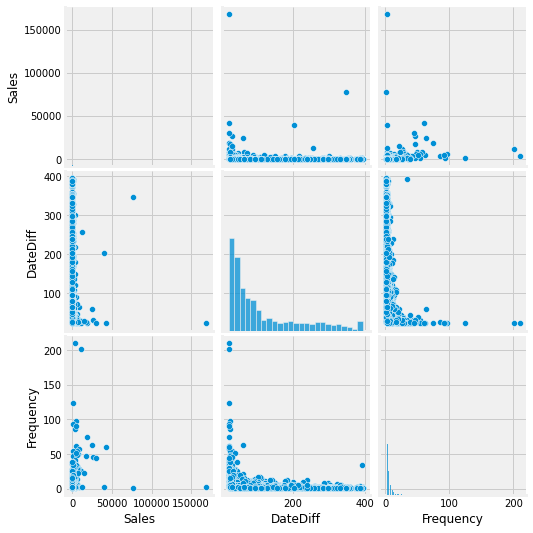

In [24]:
# 查看数据大概分布
sns.pairplot(df_rfm)

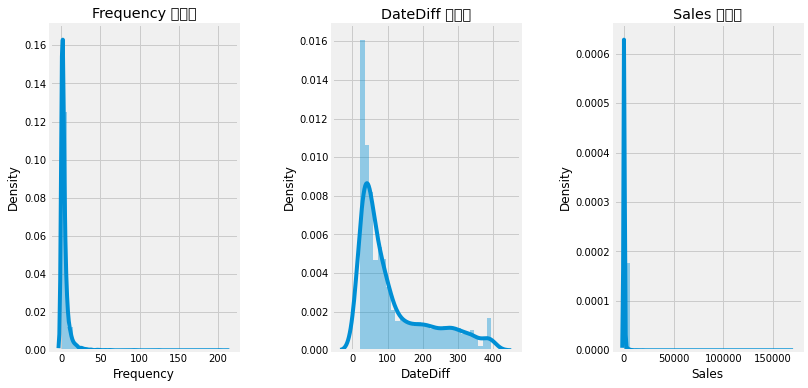

In [33]:
# 单独拿出来看分布直方图
plt.figure(1,figsize=(12,6))
n=0
for x in ['Frequency','DateDiff','Sales']:
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df_rfm[x],bins=30)
    plt.title('{} 直方图'.format(x))
plt.show()

In [34]:
"""
R F M 分别对应                    对应本实例的字段
R = Recency  最近一次消费         = 每个客户最近一次下单距离现在的天数
F = Frequency 消费频率            = 每个客户累计单数
M = Monetary  消费金额            = 每个客户累计交易金
"""

'\nR F M 分别对应                    对应本实例的字段\nR = Recency  最近一次消费         = 每个客户最近一次下单距离现在的天数\nF = Frequency 消费频率            = 每个客户累计单数\nM = Monetary  消费金额            = 每个客户累计交易金\n'

In [35]:
# 根据客户消费间隔、频率和金额把客户分为8个类型
k=8
clf=KMeans(n_clusters=k)
clf.fit(df_rfm)

KMeans()

In [36]:
# 计算用于划分客户的阙值，R、F、M的均值（*通过分布直方图可以发现该份数据不适合用中位数来分层，因此这里用均值做分层）
rmd = df_rfm['DateDiff'].mean()
fmd = df_rfm['Frequency'].mean()
mmd = df_rfm['Sales'].mean()
rmd,fmd,mmd

(114.0414842129523, 4.271952062687255, 296.7611131597142)

In [37]:
def customer_type(frame): 
    customer_type = []
    for i in range(len(frame)):
        if frame.iloc[i,1]<=rmd and frame.iloc[i,2]>=fmd and frame.iloc[i,0]>=mmd:
            customer_type.append('重要价值用户')
        elif  frame.iloc[i,1]>rmd and frame.iloc[i,2]>=fmd and frame.iloc[i,0]>=mmd:
            customer_type.append('重要唤回用户')
        elif  frame.iloc[i,1]<=rmd and frame.iloc[i,2]<fmd and frame.iloc[i,0]>=mmd:
            customer_type.append('重要深耕用户')
        elif  frame.iloc[i,1]>rmd and frame.iloc[i,2]<fmd and frame.iloc[i,0]>=mmd:
            customer_type.append('重要挽留用户')
        elif  frame.iloc[i,1]<=rmd and frame.iloc[i,2]>=fmd and frame.iloc[i,0]<mmd:
            customer_type.append('潜力用户')
        elif  frame.iloc[i,1]>rmd and frame.iloc[i,2]>=fmd and frame.iloc[i,0]<mmd:
            customer_type.append('一般维持用户')
        elif  frame.iloc[i,1]<=rmd and frame.iloc[i,2]<fmd and frame.iloc[i,0]<mmd:
            customer_type.append('新用户')
        elif frame.iloc[i,1]>rmd and frame.iloc[i,2]<fmd and frame.iloc[i,0]<mmd:
            customer_type.append('流失用户')
    frame['classification'] = customer_type

In [39]:
customer_type(df_rfm)

print('不同类型的客户总数：')
print('--------------------')
df_rfm.groupby(by='classification').size().reset_index(name='客户数')

不同类型的客户总数：
--------------------


,classification,客户数
0,一般维持用户,51
1,新用户,1803
2,流失用户,1298
3,潜力用户,686
4,重要价值用户,361
5,重要唤回用户,17
6,重要挽留用户,58
7,重要深耕用户,65


In [40]:
print('不同类型的客户消费总额：')
print('------------------------')
df_rfm.groupby('classification').Sales.sum().reset_index(name='金额')

不同类型的客户消费总额：
------------------------


,classification,金额
0,一般维持用户,6332.64
1,新用户,89209.31
2,流失用户,53116.41
3,潜力用户,93804.10
4,重要价值用户,617878.42
5,重要唤回用户,22002.41
6,重要挽留用户,168550.12
7,重要深耕用户,236753.06


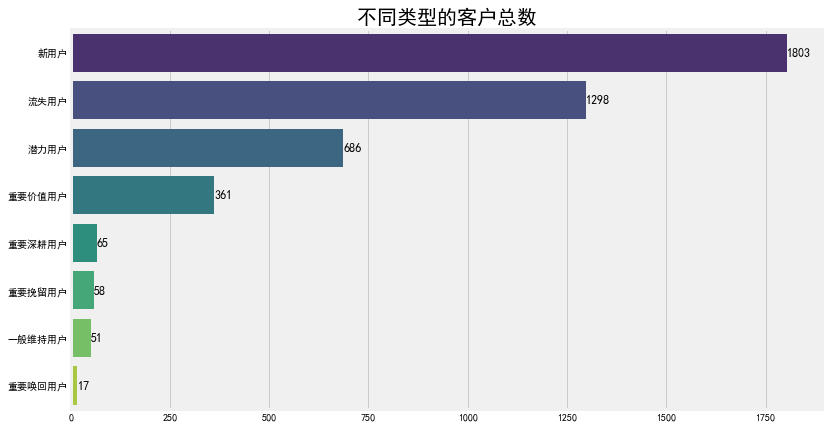

In [43]:
#  可视化不同类型客户数量
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

plt.figure(1,figsize=(12,7))
sns.countplot(y="classification",order=df_rfm['classification'].value_counts().index ,
data=df_rfm,palette='viridis')
plt.title('不同类型的客户总数',fontsize=20)
plt.xlabel('')
plt.ylabel('')

con=list(df_rfm.groupby('classification').classification.count().values)
con=sorted(con,reverse=True)

for x,y in enumerate(con):
    plt.text(y+0.1,x,'%s' %y,va='center',size=12)
plt.show()

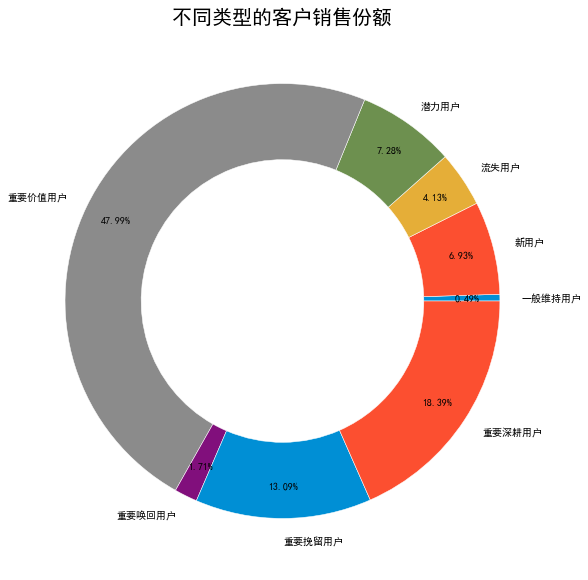

In [44]:
# 不同类型客户的消费份额
plt.figure(1,figsize=(10,10))
labels=df_rfm.groupby('classification').Sales.sum().index
size=df_rfm.groupby('classification').Sales.sum()

# explode=[0,0,0,0,0.1,0,0,0]

plt.pie(size,labels=labels,autopct='%.2f%%',wedgeprops={'width':0.35,'edgecolor':'w'},
pctdistance=0.85)

plt.title('不同类型的客户销售份额',fontsize=20)
plt.axis('off')
plt.show()

### 方法二：假设不规定8个分类利用模型来选择最优分类，利用最近交易间隔，交易金额进行细分

In [45]:
X= df_rfm[['Sales' , 'DateDiff' ,'Frequency']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

In [46]:
algorithm = (KMeans(n_clusters = 5,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [47]:
df_rfm['label3'] =  labels3
trace1 = go.Scatter3d(
    x= df_rfm['Sales'],
    y= df_rfm['DateDiff'],
    z= df_rfm['Frequency'],
    mode='markers',
     marker=dict(
        color = df_rfm['label3'], 
        size=10,
        line=dict(
            color= df_rfm['label3'],
#             width= 10
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    height=800,
    width=800,
    title= 'Sales  VS  DateDiff  VS  Frequency',
    scene = dict(
            xaxis = dict(title  = 'Sales'),
            yaxis = dict(title  = 'DateDiff'),
            zaxis = dict(title  = 'Frequency')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [48]:
# 由于数据的原因，该图的视觉效果不佳，通过前面的直方分布图也可发现该份数据严重右偏态分布不适合直接利用方法二进行分类，
# 需要先对数据进行处理和数据规范后再用方法二进行分类